In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.coordinates import SkyCoord, EarthLocation
from astropy.io import fits
from spectral_cube import SpectralCube
from spectral_cube import BooleanArrayMask
from astropy.convolution import Gaussian1DKernel, convolve
import aplpy  
from astropy.wcs import WCS
from reproject import reproject_interp
from astroquery.vizier import Vizier
from astroquery.skyview import SkyView
from astropy.time import Time
import csv
from astropy.io import ascii
import pandas as pd

Vizier.ROW_LIMIT = -1

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = '16'
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [61]:
atca_sources = ['16:00:37 -62:09:00', '17:20:37 -62:09:00']
c = SkyCoord(atca_sources[0], unit=(u.hourangle, u.deg))
print(c.ra.deg, c.dec.deg)
c = SkyCoord(atca_sources[1], unit=(u.hourangle, u.deg))
print(c.ra.deg, c.dec.deg)

240.1541666666666 -62.15
260.1541666666666 -62.15


In [55]:
# read in ASKAP catalogue

data_1 = pd.read_csv('/Users/denes/Research/high_lat_HI/ASKAP_data/RACS/AS110_Continuum_Island_Catalogue_8676_2646.csv')
data_2 = pd.read_csv('/Users/denes/Research/high_lat_HI/ASKAP_data/RACS/AS110_Continuum_Island_Catalogue_8676_2658.csv')
data_3 = pd.read_csv('/Users/denes/Research/high_lat_HI/ASKAP_data/RACS/AS110_Continuum_Island_Catalogue_8676_2646.csv')
data_4 = pd.read_csv('/Users/denes/Research/high_lat_HI/ASKAP_data/RACS/AS110_Continuum_Island_Catalogue_8674_2634.csv')
data_5 = pd.read_csv('/Users/denes/Research/high_lat_HI/ASKAP_data/RACS/AS110_Continuum_Island_Catalogue_8676_1633.csv')


df_1 = pd.DataFrame(data_1)
df_2 = pd.DataFrame(data_2)
df_3 = pd.DataFrame(data_3)
df_4 = pd.DataFrame(data_4)
df_5 = pd.DataFrame(data_5)

# concatenate catalogues
df = pd.concat([df_1, df_2, df_3, df_4, df_5])

In [56]:
df_1.keys()

Index(['id', 'catalogue_id', 'other_sbids', 'first_sbid', 'project_id',
       'island_id', 'island_name', 'n_components', 'ra_hms_cont',
       'dec_dms_cont', 'ra_deg_cont', 'dec_deg_cont', 'freq', 'maj_axis',
       'min_axis', 'pos_ang', 'flux_int', 'flux_int_err', 'flux_peak',
       'mean_background', 'background_noise', 'max_residual', 'min_residual',
       'mean_residual', 'rms_residual', 'stddev_residual', 'x_min', 'x_max',
       'y_min', 'y_max', 'n_pix', 'solid_angle', 'beam_area', 'x_ave', 'y_ave',
       'x_cen', 'y_cen', 'x_peak', 'y_peak', 'flag_i1', 'flag_i2', 'flag_i3',
       'flag_i4', 'comment', 'quality_level', 'released_date'],
      dtype='object')

In [83]:
sources = df[df['flux_peak']>150]
print(len(sources))
ra = np.array(sources['ra_hms_cont'])
dec = np.array(sources['dec_dms_cont'])
F_peak = np.array(sources['flux_peak'])

383


In [58]:
# read in HI data
hi_data = fits.open('/Users/denes/Research/high_lat_HI/GAS_data/gass_Norma_v2.fits')  # Open the FITS file for reading
d = hi_data[0].data
h = hi_data[0].header
#d = d[0,:,:]
#del h['*3']
#h['NAXIS'] = 2
h['CUNIT3'] = 'm/s'
c = 1.823 * 10**18
#nhi = c*d

cube = SpectralCube(data=d, wcs=WCS(h))
moment_0 = cube.with_spectral_unit(u.km/u.s).moment(order=0)
nhi = c*moment_0.value

del h['*3']
h['NAXIS'] = 2

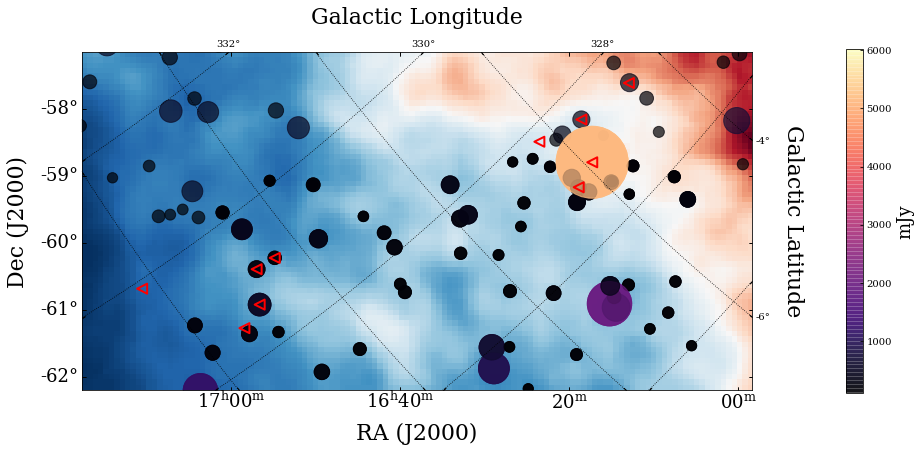

In [59]:
# make fancy HI overlay plots

# select continuum sources to plot

atca_sources = ['16:17:17 -58:48:09', '16:18:53 -59:10:29', '16:23:32 -58:29:43', '16:12:57 -57:37:10', '16:18:34 -58:09:51','17:10:29.65 -60:41:17', '16:54:49.42 -60:13:43.10', '16:56:36.06 -60:55:31.10', '16:56:57.61 -60:23:50.60', '16:58:24.28 -61:16:35.80']


# plot figure
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(111, projection=WCS(h))

# Display the moment map image
im = ax.imshow(nhi, cmap='RdBu_r')
#ax.contour(co_reprojected, levels=[0.4, 0.8], cmap='Blues_r', alpha=0.7)

x_lim = ax.get_xlim()
y_lim = ax.get_ylim()

c_ra = []
c_dec = []

for i in range(0, len(ra)):
    coord = '{} {}'.format(ra[i], dec[i])
    c_0 = SkyCoord(coord, unit=(u.hourangle, u.deg))
    c_ra.append(c_0.ra.value)
    c_dec.append(c_0.dec.value)

cb = ax.scatter(c_ra, c_dec, transform=ax.get_transform('fk5'), marker='o', s=F_peak, c =F_peak, cmap='magma', alpha=0.7)


for j in range(0, len(atca_sources)):
    c3 = SkyCoord(atca_sources[j], unit=(u.hourangle, u.deg))
    ax.scatter(c3.ra, c3.dec, transform=ax.get_transform('fk5'), marker='<', s=100, edgecolor='r', linewidth=2, facecolor='none')
    #ax.text(c3.ra.value, c3.dec.value, transform=ax.get_transform('fk5'),s=sources[j],fontsize=10)


#ax.set_title('Hydra', fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.coords['ra'].set_axislabel('RA (J2000)', fontsize=22)
ax.coords['dec'].set_axislabel('Dec (J2000)', fontsize=22)

cbar_hi = plt.colorbar(cb, orientation='vertical', fraction=0.022, pad=0.12)
cbar_hi.set_label('mJy', size=18)

overlay = ax.get_coords_overlay('galactic')
overlay.grid(color='k', ls='dotted')
overlay[0].set_axislabel('Galactic Longitude', fontsize=22)
overlay[1].set_axislabel('Galactic Latitude', fontsize=22)

ax.set_xlim(x_lim)
ax.set_ylim(y_lim)

#plt.colorbar(im)
fig.savefig('Norma_ASKAP_continuum_sources_obs.png',dpi=200)

# Make source list based on ra dec

In [84]:
source_list = sources[['ra_hms_cont', 'dec_dms_cont', 'ra_deg_cont', 'dec_deg_cont', 'flux_int', 'flux_peak', 'maj_axis', 'n_pix']]
source_list.to_csv('./bright_ASKAP_source_list.csv')

In [93]:
source_list_1 = source_list[source_list['dec_deg_cont']>-59.50]
source_list_1 = source_list_1[source_list_1['dec_deg_cont']<-57.8]
source_list_1 = source_list_1[source_list_1['ra_deg_cont']<244]
source_list_1 = source_list_1[source_list_1['ra_deg_cont']>240.]

ra_1 = np.array(source_list_1['ra_hms_cont'])
dec_1 = np.array(source_list_1['dec_dms_cont'])
source_list_1

,ra_hms_cont,dec_dms_cont,ra_deg_cont,dec_deg_cont,flux_int,flux_peak,maj_axis,n_pix
661,16:15:02.1,-59:05:56,243.758551,-59.098964,287.651,218.232,24.07,330
1583,16:05:59.2,-59:21:19,241.496745,-59.355405,271.401,243.638,23.42,257
326,16:10:51.2,-57:50:50,242.713293,-57.847335,200.740,189.431,18.63,317
384,16:15:02.2,-59:05:56,243.759144,-59.099041,274.489,212.206,21.39,291
553,16:00:11.9,-58:10:48,240.049407,-58.180043,1151.952,684.557,60.38,1414
885,16:05:59.4,-59:21:19,241.497615,-59.355450,261.532,241.185,19.26,300
661,16:15:02.1,-59:05:56,243.758551,-59.098964,287.651,218.232,24.07,330
1583,16:05:59.2,-59:21:19,241.496745,-59.355405,271.401,243.638,23.42,257
661,16:15:02.1,-59:05:56,243.758551,-59.098964,287.651,218.232,24.07,330
1583,16:05:59.2,-59:21:19,241.496745,-59.355405,271.401,243.638,23.42,257


In [101]:
source_list_2 = source_list[source_list['dec_deg_cont']<-60.50]
source_list_2 = source_list_2[source_list_2['dec_deg_cont']>-62.2]
source_list_2 = source_list_2[source_list_2['ra_deg_cont']>244]
source_list_2 = source_list_2[source_list_2['ra_deg_cont']<251]

ra_2 = np.array(source_list_2['ra_hms_cont'])
dec_2 = np.array(source_list_2['dec_dms_cont'])
source_list_2

,ra_hms_cont,dec_dms_cont,ra_deg_cont,dec_deg_cont,flux_int,flux_peak,maj_axis,n_pix
187,16:27:00.2,-60:43:27,246.750942,-60.724212,196.553,167.266,22.79,461
198,16:39:25.7,-60:44:22,249.857034,-60.739676,177.716,167.724,22.43,340
243,16:28:54.5,-61:52:37,247.227056,-61.877005,984.717,948.250,22.54,434
368,16:29:09.2,-61:33:45,247.288274,-61.562732,664.705,646.869,22.32,382
657,16:21:50.9,-60:45:17,245.462031,-60.754876,271.135,215.141,22.47,412
187,16:27:00.2,-60:43:27,246.750942,-60.724212,196.553,167.266,22.79,461
198,16:39:25.7,-60:44:22,249.857034,-60.739676,177.716,167.724,22.43,340
243,16:28:54.5,-61:52:37,247.227056,-61.877005,984.717,948.250,22.54,434
368,16:29:09.2,-61:33:45,247.288274,-61.562732,664.705,646.869,22.32,382
657,16:21:50.9,-60:45:17,245.462031,-60.754876,271.135,215.141,22.47,412


In [113]:
source_list_3 = source_list[source_list['dec_deg_cont']<-61.00]
source_list_3 = source_list_3[source_list_3['dec_deg_cont']>-62.3]
source_list_3 = source_list_3[source_list_3['ra_deg_cont']>251]
source_list_3 = source_list_3[source_list_3['ra_deg_cont']<260]

ra_3 = np.array(source_list_3['ra_hms_cont'])
dec_3 = np.array(source_list_3['dec_dms_cont'])
source_list_3

,ra_hms_cont,dec_dms_cont,ra_deg_cont,dec_deg_cont,flux_int,flux_peak,maj_axis,n_pix
176,16:44:45.6,-61:35:19,251.190072,-61.588856,176.355,166.441,22.41,348
546,17:03:36.4,-62:12:40,255.901499,-62.211351,1229.005,1183.452,22.36,354
809,17:02:09.8,-61:38:37,255.540888,-61.643862,241.707,222.509,22.66,321
1045,17:04:15.5,-61:14:09,256.064695,-61.235912,231.085,217.046,23.07,282
1708,16:57:48.8,-61:21:38,254.453342,-61.360637,266.702,249.927,22.78,364
2145,16:49:14.6,-61:55:46,252.311020,-61.929657,248.500,236.392,23.20,370
176,16:44:45.6,-61:35:19,251.190072,-61.588856,176.355,166.441,22.41,348
546,17:03:36.4,-62:12:40,255.901499,-62.211351,1229.005,1183.452,22.36,354
809,17:02:09.8,-61:38:37,255.540888,-61.643862,241.707,222.509,22.66,321
1045,17:04:15.5,-61:14:09,256.064695,-61.235912,231.085,217.046,23.07,282


In [115]:
source_list_4 = source_list[source_list['dec_deg_cont']<-59.00]
source_list_4 = source_list_4[source_list_4['dec_deg_cont']>-60.3]
source_list_4 = source_list_4[source_list_4['ra_deg_cont']>246]
source_list_4 = source_list_4[source_list_4['ra_deg_cont']<251]

ra_4 = np.array(source_list_4['ra_hms_cont'])
dec_4 = np.array(source_list_4['dec_dms_cont'])
source_list_4

,ra_hms_cont,dec_dms_cont,ra_deg_cont,dec_deg_cont,flux_int,flux_peak,maj_axis,n_pix
271,16:41:53.1,-59:51:13,250.471266,-59.853773,569.492,185.778,42.58,592
1232,16:40:39.6,-60:04:10,250.164958,-60.069703,242.347,234.943,21.97,317
2348,16:32:54.6,-59:38:30,248.227582,-59.641755,296.261,281.197,22.40,437
2867,16:34:05.0,-59:08:15,248.520662,-59.137675,536.163,312.324,49.08,705
3630,16:31:57.7,-59:35:06,247.990218,-59.585040,617.571,343.069,45.42,513
271,16:41:53.1,-59:51:13,250.471266,-59.853773,569.492,185.778,42.58,592
1232,16:40:39.6,-60:04:10,250.164958,-60.069703,242.347,234.943,21.97,317
2348,16:32:54.6,-59:38:30,248.227582,-59.641755,296.261,281.197,22.40,437
2867,16:34:05.0,-59:08:15,248.520662,-59.137675,536.163,312.324,49.08,705
3630,16:31:57.7,-59:35:06,247.990218,-59.585040,617.571,343.069,45.42,513


In [119]:
source_list_5 = source_list[source_list['dec_deg_cont']<-59.00]
source_list_5 = source_list_5[source_list_5['dec_deg_cont']>-60]
source_list_5 = source_list_5[source_list_5['ra_deg_cont']>251]
source_list_5 = source_list_5[source_list_5['ra_deg_cont']<260]

ra_5 = np.array(source_list_5['ra_hms_cont'])
dec_5 = np.array(source_list_5['dec_dms_cont'])
source_list_5

,ra_hms_cont,dec_dms_cont,ra_deg_cont,dec_deg_cont,flux_int,flux_peak,maj_axis,n_pix
231,17:00:59.2,-59:33:04,255.246777,-59.551301,186.729,169.586,22.73,252
282,16:50:16.3,-59:08:16,252.567838,-59.137859,255.066,187.848,24.12,339
3961,16:49:39.1,-59:56:35,252.412750,-59.943253,487.869,331.004,21.54,408
4628,16:58:42.0,-59:48:07,254.675163,-59.802002,488.856,427.866,23.99,367
231,17:00:59.2,-59:33:04,255.246777,-59.551301,186.729,169.586,22.73,252
282,16:50:16.3,-59:08:16,252.567838,-59.137859,255.066,187.848,24.12,339
3961,16:49:39.1,-59:56:35,252.412750,-59.943253,487.869,331.004,21.54,408
4628,16:58:42.0,-59:48:07,254.675163,-59.802002,488.856,427.866,23.99,367
282,17:03:50.4,-59:37:33,255.959907,-59.626010,178.947,161.401,19.22,247
848,17:08:33.1,-59:36:29,257.137878,-59.608153,172.798,163.512,19.57,243


In [126]:
source_list_6 = source_list[source_list['dec_deg_cont']<-57.80]
source_list_6 = source_list_6[source_list_6['dec_deg_cont']>-59]
source_list_6 = source_list_6[source_list_6['ra_deg_cont']>251]
source_list_6 = source_list_6[source_list_6['ra_deg_cont']<258]

ra_6 = np.array(source_list_6['ra_hms_cont'])
dec_6 = np.array(source_list_6['dec_dms_cont'])
source_list_6

,ra_hms_cont,dec_dms_cont,ra_deg_cont,dec_deg_cont,flux_int,flux_peak,maj_axis,n_pix
332,17:04:18.2,-57:51:03,256.075931,-57.851082,361.316,181.637,21.96,1105
2777,16:54:40.7,-58:01:45,253.669437,-58.029324,249.875,234.428,18.50,291
4439,17:02:42.1,-58:03:13,255.675292,-58.053877,474.544,445.549,18.66,411
4550,16:52:01.4,-58:17:11,253.005868,-58.286428,503.013,487.707,18.59,259
4787,17:07:06.5,-58:02:19,256.777152,-58.038665,1002.709,508.958,37.33,470


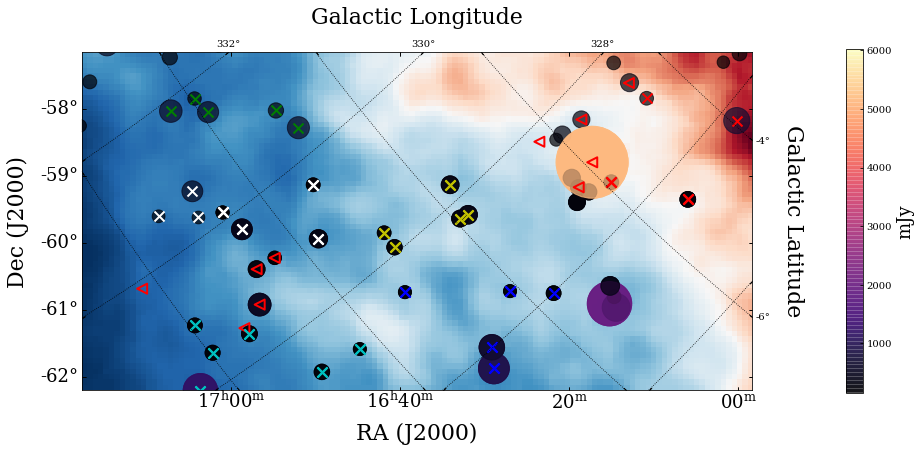

In [127]:
# make fancy HI overlay plots

# select continuum sources to plot

atca_sources = ['16:17:17 -58:48:09', '16:18:53 -59:10:29', '16:23:32 -58:29:43', '16:12:57 -57:37:10', '16:18:34 -58:09:51','17:10:29.65 -60:41:17', '16:54:49.42 -60:13:43.10', '16:56:36.06 -60:55:31.10', '16:56:57.61 -60:23:50.60', '16:58:24.28 -61:16:35.80']


# plot figure
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(111, projection=WCS(h))

# Display the moment map image
im = ax.imshow(nhi, cmap='RdBu_r')
#ax.contour(co_reprojected, levels=[0.4, 0.8], cmap='Blues_r', alpha=0.7)

x_lim = ax.get_xlim()
y_lim = ax.get_ylim()

c_ra = []
c_dec = []

for i in range(0, len(ra)):
    coord = '{} {}'.format(ra[i], dec[i])
    c_0 = SkyCoord(coord, unit=(u.hourangle, u.deg))
    c_ra.append(c_0.ra.value)
    c_dec.append(c_0.dec.value)

cb = ax.scatter(c_ra, c_dec, transform=ax.get_transform('fk5'), marker='o', s=F_peak, c =F_peak, cmap='magma', alpha=0.7)


for j in range(0, len(atca_sources)):
    c3 = SkyCoord(atca_sources[j], unit=(u.hourangle, u.deg))
    ax.scatter(c3.ra, c3.dec, transform=ax.get_transform('fk5'), marker='<', s=100, edgecolor='r', linewidth=2, facecolor='none')
    #ax.text(c3.ra.value, c3.dec.value, transform=ax.get_transform('fk5'),s=sources[j],fontsize=10)

for i in range(0, len(ra_1)):
    coord = '{} {}'.format(ra_1[i], dec_1[i])
    c_1 = SkyCoord(coord, unit=(u.hourangle, u.deg))
    ax.scatter(c_1.ra, c_1.dec, transform=ax.get_transform('fk5'), marker='x', s=100, edgecolor='r', linewidth=2, facecolor='r')

for i in range(0, len(ra_2)):
    coord = '{} {}'.format(ra_2[i], dec_2[i])
    c_1 = SkyCoord(coord, unit=(u.hourangle, u.deg))
    ax.scatter(c_1.ra, c_1.dec, transform=ax.get_transform('fk5'), marker='x', s=100, edgecolor='b', linewidth=2, facecolor='b')

for i in range(0, len(ra_3)):
    coord = '{} {}'.format(ra_3[i], dec_3[i])
    c_1 = SkyCoord(coord, unit=(u.hourangle, u.deg))
    ax.scatter(c_1.ra, c_1.dec, transform=ax.get_transform('fk5'), marker='x', s=100, edgecolor='c', linewidth=2, facecolor='c')

for i in range(0, len(ra_4)):
    coord = '{} {}'.format(ra_4[i], dec_4[i])
    c_1 = SkyCoord(coord, unit=(u.hourangle, u.deg))
    ax.scatter(c_1.ra, c_1.dec, transform=ax.get_transform('fk5'), marker='x', s=100, edgecolor='y', linewidth=2, facecolor='y')

for i in range(0, len(ra_5)):
    coord = '{} {}'.format(ra_5[i], dec_5[i])
    c_1 = SkyCoord(coord, unit=(u.hourangle, u.deg))
    ax.scatter(c_1.ra, c_1.dec, transform=ax.get_transform('fk5'), marker='x', s=100, edgecolor='w', linewidth=2, facecolor='w')

for i in range(0, len(ra_6)):
    coord = '{} {}'.format(ra_6[i], dec_6[i])
    c_1 = SkyCoord(coord, unit=(u.hourangle, u.deg))
    ax.scatter(c_1.ra, c_1.dec, transform=ax.get_transform('fk5'), marker='x', s=100, edgecolor='g', linewidth=2, facecolor='g')
    
#ax.set_title('Hydra', fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.coords['ra'].set_axislabel('RA (J2000)', fontsize=22)
ax.coords['dec'].set_axislabel('Dec (J2000)', fontsize=22)

cbar_hi = plt.colorbar(cb, orientation='vertical', fraction=0.022, pad=0.12)
cbar_hi.set_label('mJy', size=18)

overlay = ax.get_coords_overlay('galactic')
overlay.grid(color='k', ls='dotted')
overlay[0].set_axislabel('Galactic Longitude', fontsize=22)
overlay[1].set_axislabel('Galactic Latitude', fontsize=22)

ax.set_xlim(x_lim)
ax.set_ylim(y_lim)

#plt.colorbar(im)
fig.savefig('Norma_ASKAP_continuum_sources_obs_v2.png',dpi=200)